# Project Report
### Wine Quality Classification
##### Names: Sean Dempsey, Raine Zhuang, Filip Veselsky, Axel Jalonen 

### Introduction
Wine quality and flavour is a complex topic, and results can be influenced by a multitude of external factors, including the grape variety, climatic conditions of growth, and geographic location (Basalekou et al., 2023). These qualitative factors help to influence the quantitative chemical and physical properties of the wine, such as the acidity, density, and sulphite concentration, among many others. In this project, we hope to use these quantitative elements to classify wines on a ten-point quality scale. To be more specific, we want to know what quantitative wine qualities, such as those mentioned above, can be used to accurately predict the quality of the wine. The dataset being used is the "Wine Quality Dataset" from Kaggle (Yasser, 2022). The dataset focuses on a specific type of red wine called "Vinho Verde", which originates from Portugal. Considering only one region makes classification simpler since geographic location and climate don't have to be factored into the equation. This dataset contains over 1100 observations of different wines in the region, and the variables describe the chemical and physical properties of the wine. The dataset has many variables, and it is likely that not all will be useful for predicting the wine quality. As such, the aim of this project is to determine the best predicting variables for wine quality from this dataset.

### Methods and Results

#### Step 1: Read in and wrangle data
The first step will be to load the required libraries for this analysis.

In [1]:
library(tidyverse)
library(tidymodels)
library(janitor)
library(repr)
install.packages("corrplot")
library(corrplot)
library(cowplot)
options(repr.matrix.max.rows = 11) # setting the number of rows to print from a data frame 

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

 The dataset is already quite tidy, but adjustments will be made to remove spaces from the variable names, change the `quality` varibale type from dbl to factor, and remove the unnecessary `id` varibale.

In [2]:
wine_data <- read_csv("https://raw.githubusercontent.com/MostLeVert/goup01dsci100/main/WineQT.csv") |>
    clean_names() |> # replaces spaces with underscores in varible names
    mutate(quality = as_factor(quality)) |>
    select(-id)

Rows: 1143 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Step 2: Summarize data 
We will compute these summary statistics on only the training set, so the first step will be to split the data into a training and testing set. 

In [3]:
set.seed(25)
wine_split <- initial_split(data = wine_data, prop = 0.7, strata = quality)
wine_test <- testing(wine_split)
wine_train <- training(wine_split)

We will first create a table that computes basic statistics for each of the variables (excluding the predicted class varibale, `quality`). This table will include the mean, max, and min for each variable. 

In [4]:
variable_summary <- wine_train |>
    select(-quality) |>
    map_df(mean) |>
    pivot_longer(fixed_acidity:alcohol, names_to = "Variables", values_to = "Mean") |>
    bind_cols(
      pivot_longer(map_df(select(wine_data, -quality), max),
                   fixed_acidity:alcohol, 
                   names_to = "Variables", 
                   values_to = "Maximum" )  
    ) |>
    bind_cols(
      pivot_longer(map_df(select(wine_data, -quality), min),
                   fixed_acidity:alcohol, 
                   names_to = "Variables", 
                   values_to = "Minimum" )  
    ) |>
    mutate(Variable = Variables...1) |>
    select(-Variables...3, - Variables...5, -Variables...1) |>
    select(Variable, Mean, Maximum, Minimum)
variable_summary
table_1_name <- "Table 1"
table_1_name

New names:
• `Variables` -> `Variables...1`
• `Variables` -> `Variables...3`
New names:
• `Variables` -> `Variables...5`


Variable,Mean,Maximum,Minimum
<chr>,<dbl>,<dbl>,<dbl>
fixed_acidity,8.32343358,15.90000,4.60000
volatile_acidity,0.53602757,1.58000,0.12000
citric_acid,0.26837093,1.00000,0.00000
residual_sugar,2.51002506,15.50000,0.90000
chlorides,0.08655013,0.61100,0.01200
free_sulfur_dioxide,15.44862155,68.00000,1.00000
total_sulfur_dioxide,45.74248120,289.00000,6.00000
density,0.99671898,1.00369,0.99007
p_h,3.31065163,4.01000,2.74000


[1] "Table 1"

We can also create a bar plot to visualize the distribution of our class variable, `quality`.

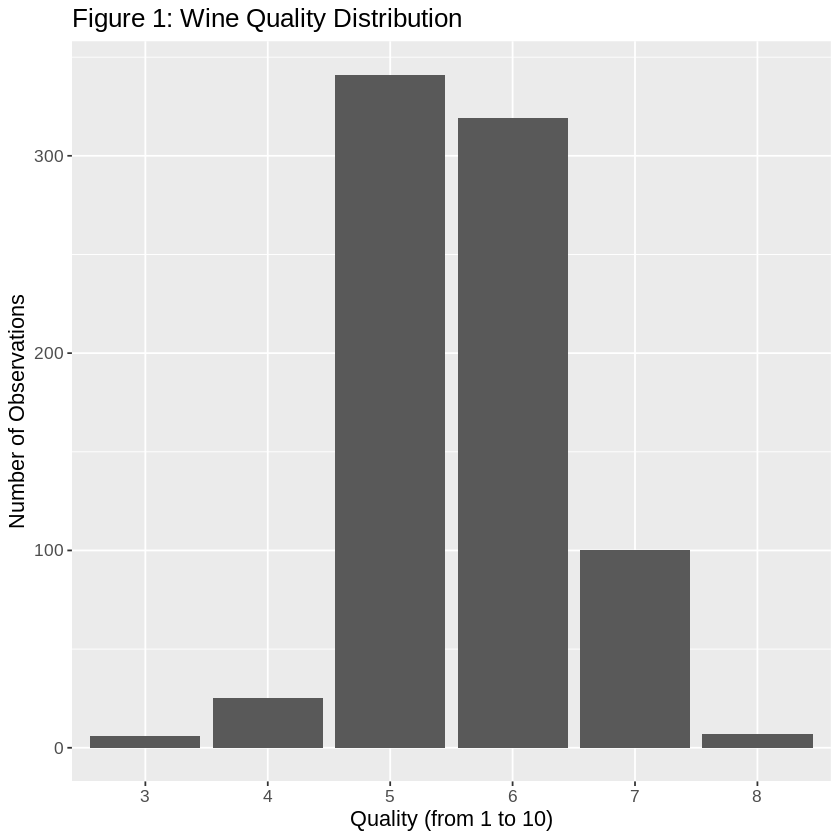

In [5]:
quality_distribution <- wine_train |>
    ggplot(aes(x = quality)) +
        geom_bar() +
        labs(x = "Quality (from 1 to 10)", 
            y = "Number of Observations", 
            title = "Figure 1: Wine Quality Distribution") +
        theme(text = element_text(size = 13))
quality_distribution

This figure clearly shows that wine quality is not evenly distributed from 1 to 10. Instead, wines with medium quality (5 or 6) are much more common than excellent or terrible wines. This will likely have a negative effect on the accuracy and precision of our model.

We will now create a correlation plot, which will help us take the first step in determining the best predictors for wine quality.

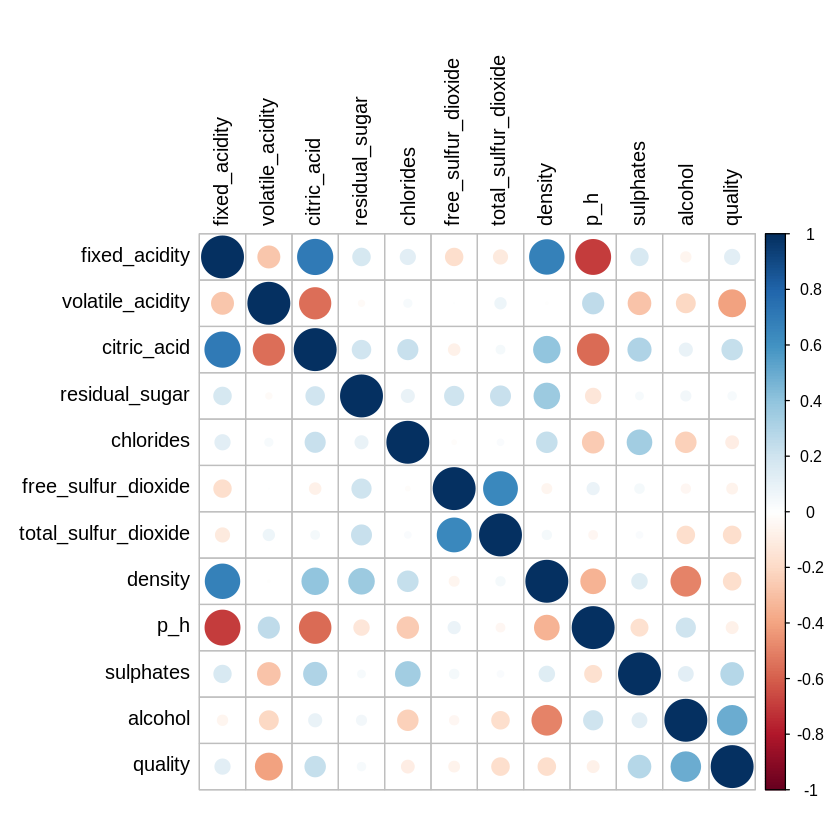

In [6]:
# Compute the correlation matrix
# We need to convert quality back to a numeric variable for this plot
wine_train_quantitative <- wine_train |> 
mutate(quality = as.numeric(quality))

correlation_matrix <- cor(wine_train_quantitative[, c('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'p_h', 'sulphates', 'alcohol', 'quality')])

# Create a correlation matrix plot to help decide which variables may be the best predictors for quality. 
#The correlation plot treats quality as a numeric variable.
corrplot <- corrplot(correlation_matrix, method = "circle", tl.col = "black")

We can see that `alcohol`, `volatile_acidity`, and `sulphates` are the most strongly correlated to wine `quality`. As such, they will be our main focus as predictors. We may want to also consider `total_sulfur_dioxide` and `density`.

#### Step 3: Determine Best Predictors and K-value
We will be doing a K-nearest neighbours classification. From above, we saw that the variables `volatile_acidity`, `sulphate`, `alcohol`, `total_sulfate_concentration`, and `density` had the highest correlation with `quality`. As such, our predictor variables will be some combination of these five. To determine which predictors to use, we will add one predictor at a time to our model, evaluating the performance of each attempt using the cross validation accuracy. We will add the predictors in and order determined by the correlation plot above; the variable with the highest correlation to `quality` will go first. We will continue adding predictors until the cross-validation accuracy stops increasing. After each predictor is added, we will reassess performance using cross-validation accuracy, and only include the predictors that contribute to a significant increase in model performance. The set of predictors that leads to the highest cross-validation accuracy will be used in our analysis. 

In the cell below, we have created a few objects that will be used many times. This includes the model specification, the cross validation folds, and the grid of K values to tune for. To determine the k-value used in each attempt, we use five fold cross validation on k-values from 1 to 15, selecting the value with the largest corresponding cross validation accuracy.

In [10]:
wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
Kvalues <- tibble(neighbors = seq(from = 1, to = 15, by = 1)) # We will test for K values between 1 and 15
wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality) # Five cross validation folds will be used

##### Attempt 1: Only `volatile_acidity` as predictor
The analysis below shows that the cross-validation accuracy of this attempt was only 0.579, which is relatively low. The best K-value for this model was K=10. 

In [38]:
set.seed(25)
try1_wine_recipe <- recipe(quality ~ volatile_acidity, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())  # Creating a recipe with only volitile_acidity as a predictor
best_K_value_try1 <- workflow() |>  # Running cross validation to determine best K value and find cross validation accuracy
    add_recipe(try1_wine_recipe) |>
    add_model(wine_spec) |>
    tune_grid(resamples = wine_vfold, grid = Kvalues) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors, .metric, mean)
best_K_value_try2 # Found to be K = 10 with accuracy of 0.579

→ A | warning: No observations were detected in `truth` for level(s): '3'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,mean
<dbl>,<chr>,<dbl>
10,accuracy,0.5789592


##### Attempt 2: Using `volatile_acidity` and `alcohol` as predictors
The analysis below shows that the cross-validation accuracy of this attempt was 0.586, which represents a small increase from the previous attempt. The best K-value for this model was K=11. 

In [39]:
set.seed(25)
try2_wine_recipe <- recipe(quality ~ volatile_acidity + alcohol, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
best_K_value_try2 <- workflow() |>  # Running cross validation to determine best K value
    add_recipe(try2_wine_recipe) |>
    add_model(wine_spec) |>
    tune_grid(resamples = wine_vfold, grid = Kvalues) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors, .metric, mean)
best_K_value_try2 # Found to be K = 11 with accuracy of 0.586

→ A | warning: No observations were detected in `truth` for level(s): '3'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,mean
<dbl>,<chr>,<dbl>
11,accuracy,0.5864282


##### Attempt 3: Using `volatile_acidity`, `sulphates`, and `alcohol` as predictors
The analysis below shows that the cross-validation accuracy of this attempt was 0.588, which represents a very small improvement from the previous attempt. The best K-value for this model was K=14. 

In [40]:
set.seed(25)
try3_wine_recipe <- recipe(quality ~ volatile_acidity + sulphates + alcohol, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
best_K_value_try3 <- workflow() |>  # Running cross validation to determine best K value
    add_recipe(try3_wine_recipe) |>
    add_model(wine_spec) |>
    tune_grid(resamples = wine_vfold, grid = Kvalues) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors, .metric, mean)
best_K_value_try3 # Found to be K = 10 with accuracy of 0.588

→ A | warning: No observations were detected in `truth` for level(s): '3'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,mean
<dbl>,<chr>,<dbl>
14,accuracy,0.5877254


##### Attempt 4: Adding `total_sulfur_dioxide` to the predictors
The analysis below shows that the cross-validation accuracy of this attempt was 0.615, which represents a reasonable improvement from the previous attempt. The best K-value for this model was K=13.

In [11]:
set.seed(25)
try4_wine_recipe <- recipe(quality ~ volatile_acidity + sulphates + alcohol + total_sulfur_dioxide, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
best_K_value_try4 <- workflow() |>  # Running cross validation to determine best K value
    add_recipe(try4_wine_recipe) |>
    add_model(wine_spec) |>
    tune_grid(resamples = wine_vfold, grid = Kvalues) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors, .metric, mean)
best_K_value_try4 # Found to be K = 13 with accuracy of 0.615

→ A | warning: No observations were detected in `truth` for level(s): '8'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: No observations were detected in `truth` for level(s): '3', '8'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x1





neighbors,.metric,mean
<dbl>,<chr>,<dbl>
15,accuracy,0.6152215


##### Attempt 5: Adding `density` to the predictors
The analysis below shows that the cross-validation accuracy of this attempt was 0.597, which represents a smaller than the cross-validation accuracy from the previous attempt. The best K-value for this model was K=12.

In [42]:
set.seed(25)
try5_wine_recipe <- recipe(quality ~ volatile_acidity + sulphates + alcohol + total_sulfur_dioxide + density, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
best_K_value_try5 <- workflow() |>  # Running cross validation to determine best K value
    add_recipe(try5_wine_recipe) |>
    add_model(wine_spec) |>
    tune_grid(resamples = wine_vfold, grid = Kvalues) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors, .metric, mean)
best_K_value_try5 # Found to be K = 12 with accuracy of 0.597

→ A | warning: No observations were detected in `truth` for level(s): '3'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,mean
<dbl>,<chr>,<dbl>
12,accuracy,0.5966178


The cross validation accuracy decreased on this attempt, so the attempt above (with `volatile_acidity`, `sulphates`, `alcohol`, and `total_sulfur_dioxide` as predictors) was the best. Additionally, we learned that the K-value that minimizes the cross validation accuracy with these predictors is K=13.

#### Step 4: Running Model and Making Predictions on Test Data
We will use `try4_wine_recipe` since it contains the right predictors. We will use K=13 as the number of neighbours.

In [16]:
final_model <- nearest_neighbor(weight = "rectangular", neighbors = 13) |> ## Create the model specifications
    set_engine("kknn") |>
    set_mode("classification")
final_predictions <- workflow() |> ## Creating a model to predict on the test data
    add_recipe(try4_wine_recipe) |>
    add_model(final_model) |>
    fit(data = wine_train) |>
    predict(wine_test) |>
    bind_cols(wine_test) ## Result is a data frame with wine_test merged with the predicted values

#### Step 5: Collecting Metrics and Evaluating the Model
We will start with computing accuracy:

In [18]:
accuracy <- metrics(final_predictions, truth = quality, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
accuracy

[1] 0.5623188

Determined by the code above, we can see that the accuracy is 0.56 (56%). This is a fairly low accuracy, which is likely caused, at least in part, by the class imbalance in the data.

Next, we will create the confusion matric for this model.

In [19]:
wine_conf_mat <- conf_mat(final_predictions, truth = quality, estimate = .pred_class)
wine_conf_mat

          Truth
Prediction  3  4  5  6  7  8
         3  0  0  0  0  0  0
         4  0  0  0  0  0  0
         5  0  3 99 44  4  0
         6  0  5 42 81 25  5
         7  0  0  1 18 14  4
         8  0  0  0  0  0  0

### Discussion

Historically, wine quality has been a largely inaccurate and difficult to predict metric (Oczkowski, 2016). Quality scores made by experts typically vary for the same wine, which makes it difficult for consumers to know what wines are actually best. Additionally, studies have shown that wine prices are often strongly correlated to quality, despite the subjectivity of this metric. This highlights the need for a more objective way to rate and score wines. 







### References

Basalekou, M., Tataridis, P., Georgakis, K., & Tsintonis, C. (2023). Measuring Wine Quality and Typicity. *Beverages, 9*(2), 41. https://doi.org/10.3390/beverages9020041

Oczkowski, E. (2016). Identifying the Effects of Objective and Subjective Quality on Wine Prices. *Journal of WIne Economics (11)*(2), 249-260. https://doi.org/10.1017/jwe.2016.1

Yasser, M.H. (2022). *Wine Quality Dataset* [Data set]. Kaggle. https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/data